全代码文件
输出说明：
''
-1- Final statevector: Statevector([-0.30020214+0.95387561j,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ],
            dims=(2, 2
            ))
-2- State |00> has amplitude (-0.3002021449212698+0.9538756062425902j)
为一次运行结果'''

-1- Final statevector: Statevector([0.92350305+0.38359109j, 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2))
-2- State |00> has amplitude (0.9235030455943206+0.3835910905873783j)
-1- Final statevector: Statevector([0.13737381+0.99051928j, 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2))
-2- State |00> has amplitude (0.13737381022655973+0.9905192760687888j)
-1- Final statevector: Statevector([ 0.        +0.j       ,  0.        +0.j       ,
              0.        +0.j       , -0.64726554-0.7622646j],
            dims=(2, 2))
-2- State |11> has amplitude (-0.6472655425927081-0.7622645980052907j)
-1- Final statevector: Statevector([0.69724243-0.71683541j, 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2))
-2- State |00> has amplitude (0.6972424266840954-0.7168354053976923j)
-1- Final statevector: Statevector

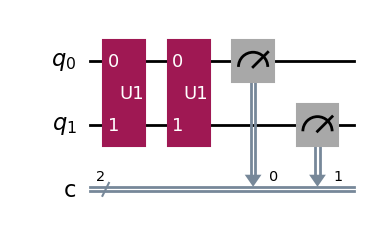

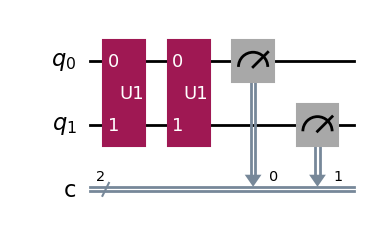

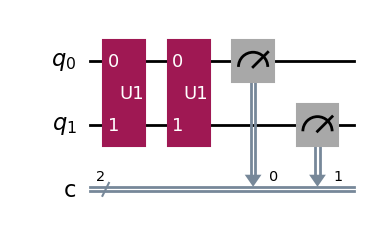

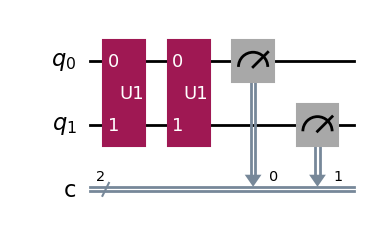

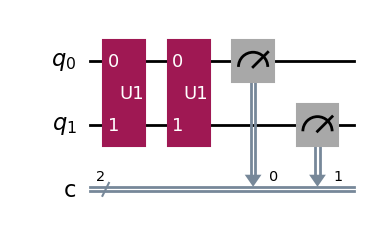

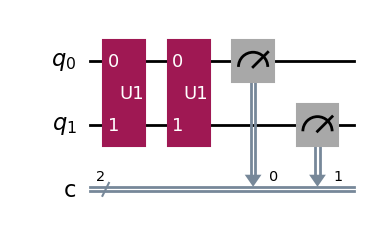

In [5]:
%matplotlib inline
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, DensityMatrix
from scipy.linalg import expm
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer

#向量子线路circ中指定量子位qubit_list添加自定义量子门
def custom_Matrix_Add(matrix, circ, qubit_list, label="custom_gate"):
    # 将矩阵转换为 Qiskit 的 Operator 对象
    custom_gate = Operator(matrix)

    # 将自定义门应用到qubit_list的每个量子比特上
    circ.unitary(custom_gate, qubit_list, label=label)
    #print('add Completed!!!')

    #返回添加操作完成后的量子线路
    return circ

#生成随机密度矩阵
def random_Density_Matrix(dim=2):
    # 随机生成一个复数向量
    psi = np.random.rand(dim) + 1j * np.random.rand(dim)
    
    # 归一化
    psi /= np.linalg.norm(psi)
    
    # 构造密度矩阵 rho = |psi><psi|
    rho = np.outer(psi, psi.conj())
    
    #print("随机生成的量子态 |psi>:\n", psi)
    #print("对应的密度矩阵 rho:\n", rho)
    #print("对应的密度矩阵 rho 的迹:\n", rho.trace())
    return rho

#生成随机matchgate:U_theta
def random_MatchGate():
    # Pauli matrices
    I = np.eye(2)
    X = np.array([[0, 1], 
                  [1, 0]])
    Z = np.array([[1, 0], 
                  [0, -1]])
    
    # Two-qubit operators
    X1X2 = np.kron(X, X)
    Z1 = np.kron(Z, I)
    Z2 = np.kron(I, Z)
    
    # Random parameters
    # alpha1 = np.random.rand()
    # alpha2 = np.random.rand()
    # beta = np.random.rand()
    alpha1, alpha2, beta = np.random.uniform(0, 2*np.pi, 3)
    
    # Matchgate
    U_theta = expm(1j * (alpha1 * Z1 + alpha2 * Z2)) @ expm(1j * beta * X1X2)
    #print('U matrix have created!!!')
    return U_theta

#创建zig-zag方式排布的量子线路  量子位、深度层数
def zig_zag_QuantumNet_Circ(qubit_num=8, depth=2):
    #创建qubit_num个量子位的量子线路
    qc = QuantumCircuit(qubit_num, qubit_num)
    
    #添加 U_theta
    for j in range(depth):
        for i in range(qubit_num//2):
            U = random_MatchGate()
            qc = custom_Matrix_Add(U, qc, [i*2, i*2+1], label="U{}".format(i+1))
        for i in range(qubit_num//2 - 1):
            U = random_MatchGate()
            qc = custom_Matrix_Add(U, qc, [i*2+1, i*2+2], label="U{}".format(i+1))

    #添加测量门
    qubit_list = [i for i in range(qubit_num)] #量子位列表
    qc.measure(range(qubit_num), range(qubit_num))
    
    return qc

#自定义输入的电路运行
def self_define_input_Circ_run(qubit_num, depth, shots=1000):
    # 定义 4x4 的自定义 U 矩阵
    custom_matrix = random_MatchGate()
    
    # 创建 qubit_num 量子比特的zig-zag方式排布的depth深度的量子线路
    circ = zig_zag_QuantumNet_Circ(qubit_num, depth)
    
    # 可视化电路
    circ.draw('mpl')
    
    # 定义输入密度矩阵
    rho = random_Density_Matrix(2** qubit_num)
    
    # 创建密度矩阵对象
    density_matrix = DensityMatrix(rho) # <<<<<<< 向量
    
    # 使用 Aer 模拟器运行
    simulator = Aer.get_backend('statevector_simulator')
    
    # 将电路编译为可执行的量子任务
    t_qc = transpile(circ, simulator)
    #qobj = assemble(t_qc)

    # 增加测试测试降低样本变异性
    # shots = shots
    
    # 运行电路并获得结果
    result = simulator.run(t_qc, initial_state=density_matrix, shots=shots).result()
    
    # 打印最终状态向量
    final_state = result.get_statevector()
    print("-1- Final statevector:", final_state)

    # 获取量子态的基态和对应的概率振幅
    def print_quantum_state(statevector):
        statevector_array = np.asarray(statevector)  # 将 Statevector 转换为 numpy 数组
        for i, amplitude in enumerate(statevector_array):
            # 忽略振幅为 0 的基态
            if np.abs(amplitude) > 1e-6:  # 过滤接近 0 的小振幅
                # 将索引 i 转换为二进制字符串，代表对应的量子态
                state = format(i, f'0{qubit_num}b')
                print(f"-2- State |{state}> has amplitude {amplitude}")

    # 输出对应的量子态和振幅
    print_quantum_state(final_state)

#主函数运行
if __name__ == "__main__":
    #多次运行，查看结果
    for i in range(6):
        self_define_input_Circ_run(qubit_num=2, depth=2, shots=1000)  #qubit_num 必须为偶数！！！
    

以下是测试部分

In [3]:
#测试部分（非主函数）
from qiskit_aer import Aer

if __name__ == "__main__":
    #将初始密度矩阵加载到量子电路中
    circ.set_density_matrix(random_Density_Matrix(2**4))
    
    # 增加测试测试降低样本变异性
    shots = 1000000

    # 密度矩阵的模拟方法
    sim_density = Aer.get_backend('aer_simulator_density_matrix')
    job_density = sim_density.run(circ, shots=shots)
    counts_density = job_density.result().get_counts(0)

    plot_histogram(counts_density, title='density counts')

NameError: name 'circ' is not defined

对应的密度矩阵 rho 的迹:
 (1+8.33504556517081e-18j)


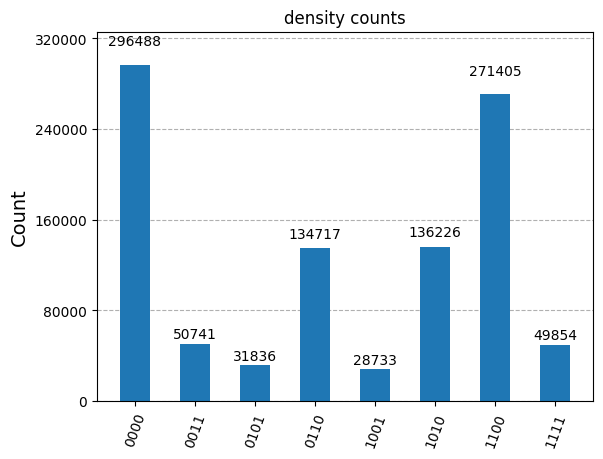

In [52]:
#测试部分（非主函数）
from qiskit_aer import Aer

if __name__ == "__main__":
    #将初始密度矩阵加载到量子电路中
    circ.set_density_matrix(random_Density_Matrix(2**4))
    
    # 增加测试测试降低样本变异性
    shots = 1000000

    # 密度矩阵的模拟方法
    sim_density = Aer.get_backend('aer_simulator_density_matrix')
    job_density = sim_density.run(circ, shots=shots)
    counts_density = job_density.result().get_counts(0)

    plot_histogram(counts_density, title='density counts')

In [5]:
a,b,c = np.random.uniform(0, 2*np.pi, 3)

In [3]:
random_Density_Matrix()

array([[0.59654774-8.14395758e-18j, 0.43175537-2.32950280e-01j],
       [0.43175537+2.32950280e-01j, 0.40345226-1.20773449e-19j]])

In [16]:
simulator = Aer.get_backend('statevector_simulator')
circ = QuantumCircuit(1)
circ.h(0)
circ.measure_all()

# rho = random_Density_Matrix(2** 2)
# print(rho)

# density_matrix = DensityMatrix(rho)
psi = np.array([1/np.sqrt(2), 1/np.sqrt(2)])

# 将电路编译为可执行的量子任务
# t_qc = transpile(circ, simulator)
#qobj = assemble(t_qc)

result = simulator.run(circ, initial_state=psi, shots=1024).result()

# 打印最终状态向量
final_state = result.get_counts()
# print("-1- Final statevector:", final_state)
print(final_state)


{'0': 516, '1': 508}
